### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        if self.criterion == 'misclass':
            self.impurity_func = self.__misclass
            self.gain_impurity = self.__gain_misclass
        elif self.criterion == 'gini':
            self.impurity_func = self.__gini
            self.gain_impurity = self.__gain_gini
        elif self.criterion == 'entropy':
            self.impurity_func = self.__entropy
            self.gain_impurity = self.__gain_entropy
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        
    def __gain_misclass(self, y):
        return 1 - np.max(np.bincount(y) / y.size)
    
    def __gain_gini(self, y):
        return 1 - np.sum((np.bincount(y) / y.size) ** 2)
    
    def __gain_entropy(self, y):
        _, p = np.unique(y, return_counts=True)
        return - np.sum((p / y.size) * np.log2((p / y.size)))
    
    def __misclass(self, y_left, y_right):
        return np.max(np.bincount(y_left)) + np.max(np.bincount(y_right))
    
    def __gini(self, y_left, y_right):
        return np.sum(np.bincount(y_left) ** 2) / y_left.size + np.sum(np.bincount(y_right) ** 2) / y_right.size
    
    def __entropy(self, y_left, y_right):
        left_size = y_left.size
        right_size = y_right.size
        _, y_left = np.unique(y_left, return_counts=True)
        _, y_right = np.unique(y_right, return_counts=True)
        return left_size + right_size + np.sum(y_left * (np.log(y_left / left_size))) + np.sum(y_right * (np.log(y_right / right_size)))
    
    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        # Ваш код здесь
        best_quality = 0
        best_feature = -1
        best_threshold = -1
        
        for f_id in np.arange(x.shape[1]):
            ids_sorted = np.argsort(x[:, f_id])
            x_, y_ = x[ids_sorted], y[ids_sorted]

            ids_margin = np.where((y_[:-1] != y_[1:]) & (x_[:-1, f_id] != x_[1:, f_id]))[0] + 1
            ids_margin = ids_margin[(ids_margin >= self.min_samples_split) & (ids_margin <= y.size - self.min_samples_split)]
            if ids_margin.size == 0:
                continue
            qualities = np.array([self.impurity_func(y_[:ind], y_[ind:]) for ind in ids_margin])
            best_arg = np.argmax(qualities)
            quality = qualities[best_arg]
            
            if quality > best_quality:
                best_quality = quality
                best_feature = f_id
                best_threshold = (x_[ids_margin[best_arg] - 1, f_id] + x_[ids_margin[best_arg], f_id]) / 2.0
                if quality >= y.size:
                    return best_feature, best_threshold
        
        return best_feature, best_threshold

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        classes_list, counts = np.unique(y, return_counts=True)
        most_class = np.argmax(classes_list)
        predict, prob = classes_list[most_class], counts[most_class] / y.size
        
        if y.size <= self.min_samples_split or depth >= self.max_depth or classes_list.size == 1:
            self.tree[node_id] = (self.LEAF_TYPE, predict, prob)
            return

        best_feature, best_threshold = self.__find_threshold(x, y)
        x_left, x_right, y_left, y_right = self.__div_samples(x, y, best_feature, best_threshold)
        
        if x_left.size == 0 or x_right.size == 0 or best_feature == -1:
            self.tree[node_id] = (self.LEAF_TYPE, predict, prob)
            return
        
        self.tree[node_id] = (self.NON_LEAF_TYPE, best_feature, best_threshold)
        self.feature_importances_[best_feature] += self.gain_impurity(y) -\
            (y_left.size * self.gain_impurity(y_left) + y_right.size * self.gain_impurity(y_right)) / y.size

        self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0)
        self.feature_importances_ /= np.sum(self.feature_importances_)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        # Ваш код здесь
        return self.feature_importances_
        

In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [7]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.9444444444444444

In [8]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9444444444444444

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [5]:
%time clf.fit(X_train, y_train)

CPU times: user 2.3 ms, sys: 805 µs, total: 3.1 ms
Wall time: 2.5 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [6]:
%time my_clf.fit(X_train, y_train)

CPU times: user 54.5 ms, sys: 4.67 ms, total: 59.2 ms
Wall time: 57.7 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [9]:
df = pd.read_csv('./speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')

df = df.iloc[:, :97]
df = df.drop(['id', 'idg', 'condtn', 'round', 'position',
              'positin1', 'order', 'partner', 'age_o', 'race_o',
              'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun',
              'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o',
              'sinc_o', 'intel_o', 'fun_o', 'amb_o',
              'shar_o', 'like_o', 'prob_o', 'met_o'], axis=1)

df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field'], axis=1)

df = df.drop(['undergra'], axis=1)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.tuition.fillna(-999)
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.drop(['from', 'zipcode'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = df.drop(['career'], axis=1)
df = df.drop(['sports', 'tvsports', 'exercise', 'dining',
              'museums', 'art', 'hiking', 'gaming',
              'clubbing', 'reading', 'tv', 'theater',
              'movies', 'concerts', 'music', 'shopping', 'yoga'], axis=1)
df = df.drop(['expnum'], axis=1)


feat = ['iid', 'wave', 'attr1_1', 'sinc1_1',
        'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1',
                                        'intel1_1', 'fun1_1',
                                        'amb1_1', 'shar1_1']].sum(axis=1)

df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
               'fun1_1', 'amb1_1', 'shar1_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100


feat = ['iid', 'wave', 'attr2_1', 'sinc2_1',
        'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1',
                                        'intel2_1', 'fun2_1',
                                        'amb2_1', 'shar2_1']].sum(axis=1)

df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
               'fun2_1', 'amb2_1', 'shar2_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)


for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    df = df.drop(feat, axis=1)

    
df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()

df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()

df_female.columns = df_female.columns + '_f'

df_female = df_female.drop(['pid_f'], axis=1)
df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)

X = df_pair.iloc[:, 1:].values
y = df_pair.iloc[:, 0].values

feature_names = df_pair.columns[1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [10]:
%time clf.fit(X_train, y_train)

CPU times: user 80.5 ms, sys: 3.28 ms, total: 83.8 ms
Wall time: 83.5 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
%time my_clf.fit(X_train, y_train)

CPU times: user 587 ms, sys: 32.2 ms, total: 619 ms
Wall time: 619 ms


In [12]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.755

In [13]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.1925

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [15]:
best_score = 0
for criterion in ('misclass', 'gini', 'entropy'):
    my_clf = MyDecisionTreeClassifier(criterion=criterion)
    score = accuracy_score(y_pred=my_clf.fit_predict(X_valid, y_valid, X_test), y_true=y_test)
    if score > best_score:
        best_score, best_criterion = score, criterion
print('Best criterion:', best_criterion)

Best criterion: entropy


In [16]:
depth_score = []
for depth in tqdm(range(5, 25)):
    my_clf = MyDecisionTreeClassifier(criterion=best_criterion, max_depth=depth)
    depth_score.append(accuracy_score(y_pred=my_clf.fit_predict(X_valid, y_valid, X_test), y_true=y_test))

In [17]:
samples_score = []
for n in tqdm(range(2, 25)):
    my_clf = MyDecisionTreeClassifier(criterion=best_criterion, min_samples_split=n)
    samples_score.append(accuracy_score(y_pred=my_clf.fit_predict(X_valid, y_valid, X_test), y_true=y_test))

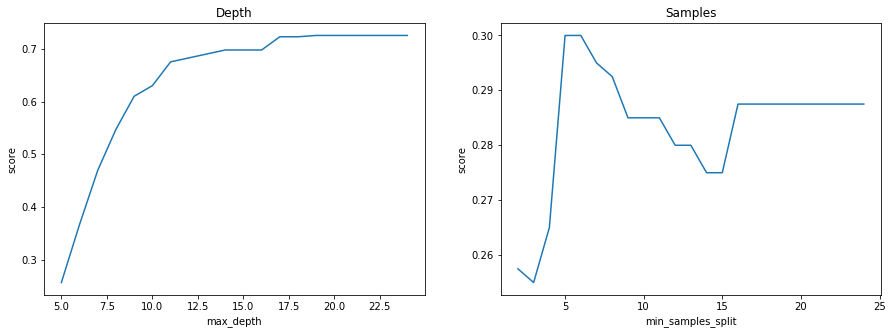

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title("Depth")
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("score")
axes[0].plot(range(5, 25), depth_score)

axes[1].set_title("Samples")
axes[1].set_xlabel("min_samples_split")
axes[1].set_ylabel("score")
axes[1].plot(range(2, 25), samples_score)
plt.show()

In [19]:
best_score = 0
for depth in tqdm(range(5, 25)):
    for n in range(2, 25):
        my_clf = MyDecisionTreeClassifier(criterion=best_criterion, min_samples_split=n, max_depth=depth)
        score = accuracy_score(y_pred=my_clf.fit_predict(X_valid, y_valid, X_test), y_true=y_test)
        if score > best_score:
            best_score, best_samples, best_depth = score, n, depth
print('Best n_samples:', best_samples)
print('Best depth:', best_depth)


Best n_samples: 2
Best depth: 19


In [20]:
my_clf = MyDecisionTreeClassifier(criterion=best_criterion, min_samples_split=best_samples, max_depth=best_depth)
score = accuracy_score(y_pred=my_clf.fit_predict(X_train, y_train, X_test), y_true=y_test)
print('Best score:', score)

Best score: 0.715


## Находим самые важные признаки (2 балла)

По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [21]:
def get_feature_values(importances, values):
    ids_sorted = np.argsort(importances)[::-1]
    return [[values[i], importances[i]] for i in ids_sorted]

In [22]:
get_feature_values(clf.feature_importances_, feature_names)[:10]

[['int_corr', 0.06838685707872669],
 ['fun2_1_f', 0.030576933327220706],
 ['age', 0.0296862516971555],
 ['amb1_1_f', 0.028890076837850876],
 ['exphappy', 0.02668097887940311],
 ['intel1_1_f', 0.026614709158455558],
 ['shar1_1', 0.026593452554663995],
 ['imprelig_f', 0.025641243545685994],
 ['intel2_1_f', 0.024306815555304718],
 ['fun3_1_f', 0.024305728035120662]]

In [23]:
get_feature_values(my_clf.get_feature_importance(), feature_names)[:10]

[['int_corr', 0.17410773051102105],
 ['age', 0.06527930983147293],
 ['field_cd', 0.057405379718338374],
 ['samerace', 0.048416476128189966],
 ['imprelig', 0.034399589664287626],
 ['exphappy', 0.03432823592746142],
 ['goal', 0.032674285669919825],
 ['attr1_1', 0.03184805177367605],
 ['imprace_f', 0.02896246720671126],
 ['imprace', 0.02865245337269436]]

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь
Осталось непонятно, как выбирать лучшее разбиение.
Пересмотрел разные лекции, перечитал разные статьи, но в итоге нашел только, что можно смотреть на индексы отсортированного массива y.
И разбивать по тем индексам, на которых происходит смена класса.

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

